<a href="https://colab.research.google.com/github/aissahm/image_analysis/blob/main/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TASK 2**


In [ ]:
import numpy as np
import cv2
from skimage import segmentation
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import os
import pandas as pd

!pip install ipython-autotime
%load_ext autotime

## **1 Introduction**

In [2]:
#returns mask for correspoinding image
def returnMaskPathFromImagePath(imagePath):
  imagePath = imagePath.replace(" ", "")
  return imagePath.replace("orig", "mask") 

#given a text file containing the name of training images return pathfile of respective masks
def returnMaskImagesPathArray(trainTextPath):
  mask_images_path_array = []
  train_images_array = []
  with open(trainTextPath, 'r') as file:
      data = file.read().replace('\n', ';')
      train_images_array = data.split(";")
  for train_image_str in train_images_array:
    mask_image_str = train_image_str.replace("./plates/orig", "/content/plates/mask")
    if len(mask_image_str) > 0:
      mask_images_path_array.append(mask_image_str)

  return mask_images_path_array

#return the subimage of interest
def returnSubimageWith(width, height, xcenter, ycenter, maskImg):
  xstart = xcenter - width//2
  xend = xcenter + width//2
  ystart = ycenter - height//2
  yend = ycenter + height//2
  return maskImg[ystart:yend+1,xstart: xend+1,:]

#returns the number of pixels representing the plate in the mask
def returnPlateNumberPixelsFromMask(maskImg):
  #maskImg = cv2.imread(maskPath)
  return maskImg.sum()/(3*255)

#given width x height, and center coordinates of subimage, returns number of plate pixels contained in subimage
def returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, maskImg):
  xstart = xcenter - width//2
  if xstart < 0:
    xstart = 0
  xend = xcenter + width//2
  ystart = ycenter - height//2
  if ystart < 0:
    ystart = 0
  yend = ycenter + height//2
  subImg = maskImg[ystart:yend+1,xstart: xend+1,:]

  return subImg.sum()/(3*255)

time: 24.6 ms


In [3]:
#function that saves an image
def saveImage(image, imagefullpath):
  cv2.imwrite(imagefullpath, image)

#Mapping from grayscale pixel to RGB using color table
def fromGrayscaleToRGBMapping(pixel, H):
  V = pixel / H
  V = (6 - 2) * V + 1
  r_p = H * max(0, (3- abs(V-4) - abs(V-5))/2 )
  g_p = H * max(0, (4- abs(V-2) - abs(V-4))/2 )
  b_p = H * max(0, (3- abs(V-1) - abs(V-2))/2 )
  return [r_p, g_p, b_p]

#Transform the grayscale image with one channel into an RGB image with 3 channels
def fromGrayscaleToRGB(grayscaleimage, bits):
  if len(grayscaleimage.shape) !=2:
    print ("Error: image is not a grayscale image")
    return 0
  
  H = 2**bits -1

  #we initiate an rgb image with 3 channels with same dimensions as grayscale image
  rgbimage = np.zeros((grayscaleimage.shape[0], grayscaleimage.shape[1], 3))
  i = 0
  while i < grayscaleimage.shape[0]:
    j = 0
    while j < grayscaleimage.shape[1]:
      r_p, g_p, b_p = fromGrayscaleToRGBMapping(grayscaleimage[i][j], H)
      rgbimage[i][j][0] = r_p
      rgbimage[i][j][1] = g_p
      rgbimage[i][j][2] = b_p
      
      j +=1
    i +=1
  
  return rgbimage

#Transform an RGB image with 3 channels into a YCbCr image with 3 channels
def fromRGBToYCbCr(rgbimage, bits):
  conversionMatrix = np.array([[0.299, 0.587, 0.144], [-0.169, -0.331, 0.500], [0.500, -0.419, -0.081]])
  bias = np.array([0, 2**(bits - 1), 2**(bits -1)])
  YCbCrimage = np.zeros((rgbimage.shape[0], rgbimage.shape[1], rgbimage.shape[2]))

  i = 0
  while i < rgbimage.shape[0]:
    j = 0
    while j < rgbimage.shape[1]:
      YCbCrimage[i][j] = conversionMatrix @ rgbimage[i][j] + bias
      j += 1
    i += 1

  return YCbCrimage

#Main function that converts a grayscale image with 1 channel to a YCbCr image with 3 channels
def fromGrayscaleToYCbCr(image, bits):
  rgbimage = fromGrayscaleToRGB(image, bits)
  if len(rgbimage.shape) < 3:
    return 0
  return fromRGBToYCbCr(rgbimage, bits)

time: 47.5 ms


**Creating the YCbCr images from grayscale original images:**

In [4]:
directory = '/content/plates/'

#creating the folder that will contain the YCbCr images
os.mkdir("ycbcrplates")

ycbcrdirectory = "/content/ycbcrplates/"

i = 0 
for filename in os.listdir(directory):
  if "orig" in filename:
    grayscaleimg = cv2.imread(directory + filename, cv2.IMREAD_GRAYSCALE)
    ycbcrimg = fromGrayscaleToYCbCr(grayscaleimg, 8)
    ycbcrimg = ycbcrimg.astype('uint8')

    ycbcrimagepath = ycbcrdirectory + filename
    cv2.imwrite(ycbcrimagepath, ycbcrimg)
    i += 1

print("Done,", i, " images from 'plates/' converted to YCbCr.")

Done, 200  images from 'plates/' converted to YCbCr.
time: 4min 19s


## **2 Improving dataset composition with superpixel segmentation**

You may use the plate mask in the training set to optimize your choice of W, H, and number Nf of superpixels, such that patch extraction will reduce the dataset size and not miss any plate, assuming that a patch is annotated as containing a plate when the number of plate pixels inside the patch is above a threshold (e.g., 90%). Figure 1a shows a plate image Iˆ = (DI,I) to which the DISF algorithm outputs the label image Lˆ = (DI,L) shown in Figure 1b for Nf = 50 superpixels. The geometric center (xl,yl) of a superpixel τ = {p ∈ DI|L(p) = l} with label l ∈ [1,Nf] can be obtained by 

xl = 1   xp,
 |τ|
p∈DI |L(p)=l
yl = 1   yp,
 |τ|
p∈DI |L(p)=l

where (xp,yp) are the coordinates of pixel p. Figure 1c illustrates a case (xl,yl) is inside the plate.

The source code of the DISF algorithm is available at https://github.com/LIDS-UNICAMP/DISF. Note that you may use it directly on the original plate image or you may want to modify its code to work for
iftMImage.


In [5]:
#returns the Geo center of each super pixel contained in an image
def returnSuperPixelsGeometricCenters(labelimage):
  width = labelimage.shape[1]
  height = labelimage.shape[0]
  nSuperPixels = np.max(labelimage) + 1
  plabelCoordinates = np.zeros(nSuperPixels)

  xCoordinates = np.zeros(nSuperPixels)
  yCoordinates = np.zeros(nSuperPixels)
  nElements = np.zeros(nSuperPixels)

  i = 0
  while i < height:
    j = 0
    while j < width:
      plabel = labelimage[i][j]
      xSum = xCoordinates[plabel]
      ySum = yCoordinates[plabel]
      nLabelElements = nElements[plabel]

      xCoordinates[plabel] = xSum + j
      yCoordinates[plabel] = ySum + i
      nElements[plabel] = nLabelElements + 1  
      j += 1
    i += 1
  
  geocenters = []
  
  plabel = 0
  while plabel < nSuperPixels :
    xCenter = xCoordinates[plabel] / nElements[plabel]
    yCenter = yCoordinates[plabel] / nElements[plabel]
    geocenters.append([int(xCenter), int(yCenter)])
    plabel += 1
  
  return geocenters

#Perform Superpixel segmentation
def returnLabelsWithSuperPixelSegmentation(imagepath, numberSuperpixels):
  originalimage = cv2.imread(imagepath)
  return segmentation.slic(originalimage, n_segments=numberSuperpixels)

time: 25.1 ms


In [6]:
#Function that loops through the superpixels number until a plate in subimage is found 
#With threshold 
def returnMinimumSuperpixelsFor(imagepath, numberSuperpixels, width, height, threshold):
  
  subimageWithPlateFound = False

  maskPath = returnMaskPathFromImagePath(imagepath)
  
  maskImage = cv2.imread(maskPath)
  
  nPlatePixelOriginalMask = returnPlateNumberPixelsFromMask(maskImage)
  
  while subimageWithPlateFound == False:
    
    labels = returnLabelsWithSuperPixelSegmentation(imagepath, numberSuperpixels)
    labelsGeocenters = returnSuperPixelsGeometricCenters(labels)

    for labelGeocenter in labelsGeocenters:
      xCenter = labelGeocenter[0]
      yCenter = labelGeocenter[1]
      nPlatePixelsSubimage = returnPlateNumberPixelsCovBySubimage(width, height, xCenter, yCenter, maskImage)
      
      if nPlatePixelsSubimage / nPlatePixelOriginalMask >= threshold:
        subimageWithPlateFound = True
        break

    if subimageWithPlateFound == False:
      numberSuperpixels += 1
      
    #stopping algorithm if number of superpixels is too high
    #then width, height aren't adequate
    if numberSuperpixels > 100 and subimageWithPlateFound == False:
      numberSuperpixels = -1
      break

  return numberSuperpixels 

time: 17.6 ms


In [7]:
superpixelsStart = 48
w = 163 #175
h = 79 #81
thresholdV = 0.9

time: 1.15 ms


In [ ]:
platesFolderPath = "/content/plates/"

f = open("train3.txt", "r")
for imgpath in f:
  imgpath = imgpath.replace("./plates/", "")
  imgpath = imgpath.replace(" ", "")
  imgpath = platesFolderPath + imgpath
  
  if len(imgpath) > 5 and superpixelsStart > 0:
    superpixelsStart = returnMinimumSuperpixelsFor(imgpath.strip(), superpixelsStart, w, h, thresholdV)
    print(imgpath, ": ", superpixelsStart)

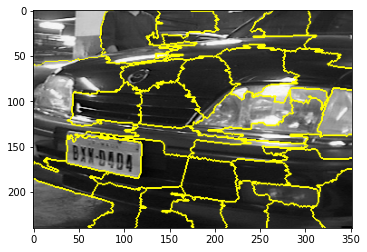

time: 493 ms


In [ ]:
imagepath = "/content/plates/orig_0181.png"

originalimage = cv2.imread(imagepath)
label = segmentation.slic(originalimage, n_segments=48)
labelsGeocenters = returnSuperPixelsGeometricCenters(label)
plt.imshow(mark_boundaries(originalimage, label))

plt.show()

In [ ]:
labelsGeocenters[19][0]

22

**Conclusion:** 

Running the superpixel segmentation algorithm, on the three cross-validation sets, we reach a converging superpixel number of 48, with Width = 163 pixels x Height = 79 pixels.



## **Creating the subimages with chosen number of superpixels**

In [8]:
def returnSubimageWIth(width, height, xcenter, ycenter, originalimage):
  xstart = xcenter - width//2
  ystart = ycenter - height//2
  xend = xcenter + width//2
  yend = ycenter + height//2

  if xstart < 0 or ystart < 0:
    print("xcoord or ycoor negative, xstart =",  xstart, ", ystart = ", ystart)
  
  return originalimage[ystart:yend+1,xstart: xend+1,:]

#verifiy the subimage fits inside the original image
def returnCenterCoordinatesSubimageInsideOrigImage(width, height, xcenter, ycenter, W, H):
  if xcenter < width // 2:
    xcenter = width // 2
    
  if xcenter >= W - width//2:
    xcenter = W - width//2 - 1

  if ycenter < height //2:
    ycenter = height //2
  
  if ycenter >= H - height//2:
    ycenter = H - height//2 - 1
  
  return [xcenter, ycenter]

#giving a name for the subimage
def returnSubimageFilename(width, height, xcenter, ycenter, subimageclass, imagepath):
  subimagefilename = imagepath.replace(".png", "")
  subimagefilename = subimagefilename + "_" + str(xcenter) + "_" + str(ycenter) + "_" + str(width) + "_" + str(height) + "_" + str (subimageclass) + ".png"
  return subimagefilename

#returns the subimage characteristics from its name
def returnSubimageDimensionsCenterCoordinates(imagename):
  imagename = imagename.replace(".png", "")
  elementsArray = imagename.split("_")
  imageID = elementsArray[1]
  width = int(elementsArray[4])
  height = int(elementsArray[5])
  xcenter = int(elementsArray[2])
  ycenter = int(elementsArray[3])
  imageclass = int(elementsArray[6])
  return [imageID, width, height, xcenter, ycenter, imageclass]

#returns the class of the subimage depending on the percentage 
#of pixel plates it contains from the original image
def returnSubimageClassWith(nPlatePixelsSubimage, nPlatePixelOriginalMask, platePixelsThreshold):
  if nPlatePixelsSubimage / nPlatePixelOriginalMask >= platePixelsThreshold:
    return 1
  return 0

#creates the subimages with a given number of superpixels
def createSubimagesWithSuperPixelsSegmentation(originalImageFolder, yCbCrImageFolder, imagename, subImageFolder, numberSuperpixels, width, height, platePixelsThreshold):
  imagepath = originalImageFolder + imagename
  yCbCrimagepath = yCbCrImageFolder + imagename
  label = returnLabelsWithSuperPixelSegmentation(imagepath, numberSuperpixels)
  labelsGeocenters = returnSuperPixelsGeometricCenters(label)
  
  maskPath = returnMaskPathFromImagePath(imagepath)
  maskImage = cv2.imread(maskPath)
  nPlatePixelOriginalMask = returnPlateNumberPixelsFromMask(maskImage)
  yCbCrOriginalImage = cv2.imread(yCbCrimagepath)

  nSubimagesCreated = 0

  W = maskImage.shape[1]
  H = maskImage.shape[0]

  subimageWithClass1 = False

  for labelGeocenter in labelsGeocenters:
    xcenter = labelGeocenter[0]
    ycenter = labelGeocenter[1]

    #we recenter the subimage if needed to fit intside the original image
    #we do that because we need to perform batch norm and we need all subimages with same dimensions
    xcenter, ycenter = returnCenterCoordinatesSubimageInsideOrigImage(width, height, xcenter, ycenter, W, H)
    nPlatePixelsSubimage = returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, maskImage)
    
    #getting the class of the subimage according to the threshold of plate pixels inside it
    subimageclass = returnSubimageClassWith(nPlatePixelsSubimage, nPlatePixelOriginalMask, platePixelsThreshold)
    
    subimage = returnSubimageWIth(width, height, xcenter, ycenter, yCbCrOriginalImage)
    subimagefilename = returnSubimageFilename(width, height, xcenter, ycenter, subimageclass, imagename)
    #saving the subimage
    cv2.imwrite(subImageFolder + subimagefilename, subimage)
    nSubimagesCreated += 1

    if subimageclass == 1:
      subimageWithClass1 = True

  #we verifiy we get at least one subimage containing enough plate pixels
  if subimageWithClass1 == False:
    print("No class 1 for ", imagename)

  return nSubimagesCreated

time: 110 ms


**Creating the subimages for the training sets**

In [9]:
number_superpixels = 48
w = 163
h = 79
thresholdV = 0.9

yCbCrPlatesFolder = "/content/ycbcrplates/"
platesFolderPath = "/content/plates/"

subimageFoldernameArray = ["train11", "train22", "train33"]
traintextfilearray = ["train1.txt", "train2.txt", "train3.txt"]

i = 0
while i < len(traintextfilearray):
  totalSubimagesCreated = 0 
  f = open(traintextfilearray[i], "r")

  os.mkdir(subimageFoldernameArray[i])

  for imgname in f:
    imgname = imgname.replace("./plates/", "")
    imgname = imgname.replace(" ", "")

    if len(imgname) > 5:
      subimagesCreated = createSubimagesWithSuperPixelsSegmentation(platesFolderPath, yCbCrPlatesFolder, imgname.strip(), subimageFoldernameArray[i] + "/", number_superpixels, w, h, thresholdV)
      totalSubimagesCreated += subimagesCreated 

  print()
  print(traintextfilearray[i])
  print("Number of subimages created :", totalSubimagesCreated)
  i += 1


train1.txt
Number of subimages created : 3166

train2.txt
Number of subimages created : 3179

train3.txt
Number of subimages created : 3161
time: 1min 32s


We managed to create at least one subimage that contains 90% or more of plate pixels for each original image by selecting the number of superpiexls to 48 in the algorithm.

**Creating the subimages for the test sets**

In [10]:
subimageFoldernameArray = ["test11", "test22", "test33"]
traintextfilearray = ["test1.txt", "test2.txt", "test3.txt"]

i = 0
while i < len(traintextfilearray):
  totalSubimagesCreated = 0 
  f = open(traintextfilearray[i], "r")

  os.mkdir(subimageFoldernameArray[i])

  for imgname in f:
    imgname = imgname.replace("./plates/", "")
    imgname = imgname.replace(" ", "")

    if len(imgname) > 5:
      subimagesCreated = createSubimagesWithSuperPixelsSegmentation(platesFolderPath, yCbCrPlatesFolder, imgname.strip(), subimageFoldernameArray[i] + "/", number_superpixels, w, h, thresholdV)
      totalSubimagesCreated += subimagesCreated 

  print()
  print(traintextfilearray[i])
  print("Number of subimages created :", totalSubimagesCreated)
  i += 1


test1.txt
Number of subimages created : 3206

test2.txt
Number of subimages created : 3193

test3.txt
Number of subimages created : 3211
time: 1min 33s


Verifying the subimages are of expected dimensions WxH

In [41]:
count = 0
for subimagename in os.listdir("/content/train33"):
  subimage = cv2.imread("/content/train33/" + subimagename)
  if subimage.shape[1] != w:
    print("subimagename = ", subimagename)
    count += 1
    break
  if subimage.shape[0] != h:
    print("subimagename = ", subimagename)
    count += 1
    break

print("different size ", count)

different size  0
time: 1.36 s


## **Kernel Bank:**

From the task 1, we concluded that the best results achieved were the ones with the following configuration:

Batch Normalization + Kernel 3x3 + Kernel normalization


From that experiment, we selected 3 kernels from the kernel bank that gave the best results in terms of pixel activation inside the plate region and deactivation outside the plate.

From now on, we will focus the next steps with those 3 kernels.

In [11]:
kernel_1 = np.array([[[-0.33718542, -1.19935276, -0.35097475], [-0.14534316, -0.67973889, -1.68150688],[ 1.39604079, -0.12181844,  1.02031156]], [[ 1.85879655, -1.79803536, -1.83444907],[ 0.65337977,  1.22915915,  1.03492271],[ 0.06496851, -1.11093411,  0.91465372]],[[-0.92305252,  0.64102434,  0.70803044], [ 0.75907349, -0.17064586,  0.45326488],[-0.06773689, -0.94498585,  0.63213406]]])
kernel_2 = np.array([[[ 0.27644533, -0.50070737,  0.83731077],  [-0.24628258, -1.3358542,   0.76395048],  [ 0.57141729, -0.30296856, -1.55914637]], [[ 0.20193021, -0.646589,   -1.50915056],  [ 0.82612689, -0.17673248,  0.54485379],  [ 1.71027041, -0.59666888,  0.50548382]],[[-1.46720401,  0.81590655, -1.48010845],[ 1.3279435,  -0.19105978,  0.04137658],[ 1.65836307, -1.42134238,  1.35243591]]])
kernel_3 = np.array([[[-1.2226035,  -0.38840306,  1.34096669],  [ 0.39297436, -1.54152036, -0.99866432],  [ 1.62115717, -0.08742015,  1.14275184]], [[ 0.88641682, -1.412767,   -1.05319195],  [ 0.67510115,  0.57186675,  0.11788186],  [-0.39275917,  0.84938246, -1.31639712]], [[ 1.24083449, -1.50916311,  0.37748861],  [ 1.1699285,   0.40277467,  1.1215329 ],[-1.24157283, -0.04045368, -0.70614203]]])

kernelbank = [kernel_1, kernel_2, kernel_3]

time: 6.41 ms


### **Batch Normalization + ReLU**

In [12]:
#ReLU function
def reLU(image):
  image[image < 0] = 0
  return image


#given a folder path with a set of images, function that returns the mean and standard deviation
#of the entire set for batch normalization
def returnBatchNormMeanAndStandarDeviationTensors(folderPath):
  meanTensor = np.array([])
  standardDeviationTensor = np.array([])

  subimagesCount = 0
  for subimagename in os.listdir(folderPath):
    subimage = cv2.imread(folderPath + "/" + subimagename)
    if meanTensor.size == 0:
      meanTensor = subimage
    else:  
      meanTensor += subimage
    subimagesCount += 1
  meanTensor = meanTensor / subimagesCount

  for subimagename in os.listdir(folderPath):
    subimage = cv2.imread(folderPath + "/" + subimagename)
    if standardDeviationTensor.size == 0:
      standardDeviationTensor = (subimage - meanTensor)**2
    else:
      standardDeviationTensor += (subimage - meanTensor)**2
  
  standardDeviationTensor = (standardDeviationTensor / (subimagesCount - 1))**0.5

  return [meanTensor, standardDeviationTensor]

#Normalize the images with Batch Norm inside a specific folder
def normalizeSubimageWithBN(meanTensor, standardDeviationTensor, subimage):
  if 0 in standardDeviationTensor:
    print("Error: standard deviation tensor contains null value")
    return -1
  return (subimage - meanTensor) / standardDeviationTensor

time: 20.5 ms


### **Convolution with Kernel Bank**

In [13]:
def returnConvolution(image, kernel):
  kwidth = kernel.shape[1]
  kheight = kernel.shape[0]
  imagewidth = image.shape[1]
  imageheight = image.shape[0]

  imagepaddedwidth = imagewidth + 2*(kwidth // 2)
  imagepaddedheight = imageheight + 2*(kheight // 2)

  imagepadded = np.zeros((imagepaddedheight, imagepaddedwidth, image.shape[2]))

  imagepadded[kheight // 2: -1*(kheight // 2), kwidth // 2:-1*(kwidth // 2), :] = image[:,:,:].copy()

  convo = np.zeros((image.shape[0], image.shape[1]))

  for y in range(image.shape[0]):
    for x in range(image.shape[1]):
      convo[y,x] = (imagepadded[ y : y + kheight, x: x + kwidth, :] * kernel).sum()
  
  return convo

#create convoluted image with b bands
def returnBbandsConvoImage(image, nkernelsArray):
  bBandsConvoImage = np.zeros((image.shape[0], image.shape[1], len(nkernelsArray)))
  for index, kernel in enumerate(nkernelsArray):
    bBandsConvoImage[:,:,index] = returnConvolution(image, kernel)
  return bBandsConvoImage

time: 18.5 ms


## **Best model from task 1**

The best model retained from task 1 was the following combination:

Batch normalization + normalized kernel 3x3 + ReLU

In [14]:
#output of image from model 1
def returnModelOutput(subimage, bKernels, meanTensor, standardDeviationTensor):
  
  #batch norm
  subimage = normalizeSubimageWithBN(meanTensor, standardDeviationTensor, subimage)

  #Convolution with kernel bank
  bBandsConvoImage = returnBbandsConvoImage(subimage, bKernels)

  #ReLU
  bBandsImages = reLU(bBandsConvoImage)

  #output from model 1
  return bBandsImages

#batch processing
def returnModuleBatchOutputWith(bKernels, foldername, trainMeanTensor = None, trainStandardDeviationTensor = None):
  meanTensor = np.array([])
  standardDeviationTensor = np.array([])
  if trainMeanTensor is None:
    meanTensor, standardDeviationTensor = returnBatchNormMeanAndStandarDeviationTensors(foldername)
  else:
    meanTensor = trainMeanTensor
    standardDeviationTensor = trainStandardDeviationTensor

  modelBatchOutput = []
  for imagename in os.listdir(foldername):
    subimage = cv2.imread(foldername + imagename)
    bBandsImages = returnModelOutput(subimage, kernelbank, meanTensor, standardDeviationTensor)
    modelBatchOutput.append([imagename, bBandsImages])

  return modelBatchOutput

time: 12.4 ms


**We create the output subimages from model 1 from task 1. This output will be the basis from which we start working in task 2.**

**For the training set:**

In [15]:
foldernamearray = ["train11/", "train22/", "train33/"]

resultsarray = []

for foldername in foldernamearray:
  results = returnModuleBatchOutputWith(kernelbank, foldername, None, None)
  resultsarray.append(results)
  print("Model output for ", foldername)
  break

Model output for  train11/
time: 10min 9s


**For the test sets:**

In [16]:
foldernamearray = ["test11/", "test22/", "test33/"]

trainfoldernamearray = ["train11/", "train22/", "train33/"]

testresultsarray = []

i = 0
for foldername in foldernamearray:
  trainmeanTensor, trainstandardDeviationTensor = returnBatchNormMeanAndStandarDeviationTensors(trainfoldernamearray[i])
  results = returnModuleBatchOutputWith(kernelbank, foldername, trainmeanTensor, trainstandardDeviationTensor)
  testresultsarray.append(results)
  print("Model output for ", foldername)
  i += 1

Model output for  test11/
Model output for  test22/
Model output for  test33/
time: 30min 43s


9.88973785742627
0.0
1.2900789640104153


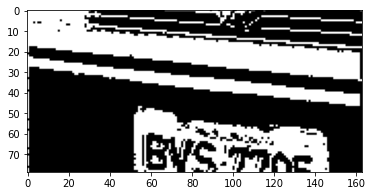

time: 162 ms


In [90]:
results[16][1].shape

bwimage = results[465][1][:,:,0].copy()

print(bwimage.max())
print(bwimage.min())
print(bwimage.mean())

pixelthreshold = 1.28

bwimage[bwimage > pixelthreshold] = 255
bwimage[bwimage <= pixelthreshold] = 0

plt.imshow(bwimage, cmap="gray")
plt.show()

In [58]:
print(returnSubimageDimensionsCenterCoordinates("orig_0004_103_145_163_79_0.png"))

['0004', 163, 79, 103, 145, 0]
time: 861 µs


## **Results Evaluations**

In [20]:
def returnScores(subimage, submask):
  submaskOutsidePlate = submask[:, :, 0].copy() 
  submaskInsidePlate = submask[:, :, 0].copy()

  submaskOutsidePlate[submaskOutsidePlate > 0] = 2 #inside plate is equal to 2
  submaskOutsidePlate[submaskOutsidePlate == 0] = 1 #outside plate is equal to 1
  submaskOutsidePlate[submaskOutsidePlate == 2] = 0 #inside plate is equal to 0

  submaskInsidePlate[submaskInsidePlate > 0] = 1

  subimagecopy = subimage.copy()
  subimagecopy[subimagecopy > 0] = 1
  
  nPlatePixels = np.sum(submaskInsidePlate)
  nActivatedPlatePixels = np.sum(subimagecopy*submaskInsidePlate)

  nDeactivatedPixelsOutsidePlate = np.sum(subimagecopy*submaskOutsidePlate)

  percentagePlatePixelsActivated = -1
  if nPlatePixels > 0:
    percentagePlatePixelsActivated = nActivatedPlatePixels/nPlatePixels
  
  width = submask.shape[1]
  height = submask.shape[0]

  percentageDeactivatedPixelsOutsidePlate = nDeactivatedPixelsOutsidePlate/(width * height - nPlatePixels) 

  return [percentagePlatePixelsActivated, percentageDeactivatedPixelsOutsidePlate]


def computeResultsScores(modelname, modelOutputResult, foldername, maskFolderPath, activationThreshold = 0):
  #
  modelresultsDF = pd.DataFrame(columns = ["Foldername", 'Imagename', "kernelID", 'percentagePlatePixelsActivated', 'percentageDeactivatedPixelsOutsidePlate'])

  for modelOutputResultElem in modelOutputResult:
    imagename = modelOutputResultElem[0]
    imageresult = modelOutputResultElem[1].copy()

    #useful?
    imageresult[imageresult <= activationThreshold] = 0
    imageresult[imageresult > activationThreshold] = 1

    imageID, width, height, xcenter, ycenter, imageclass = returnSubimageDimensionsCenterCoordinates(imagename)
    imagemask = cv2.imread(maskFolderPath + "mask_" + imageID + ".png", 1)
    submask = returnSubimageWith(width, height, xcenter, ycenter, imagemask)

    #getting model scores on image
    index = 0
    while index < imageresult.shape[2]:
      percentagePlatePixelsActivated, percentageDeactivatedPixelsOutsidePlate = returnScores(imageresult[:,:,index], submask)
      modelresultsDF = modelresultsDF.append({"Foldername": foldername,'Imagename' : imagename, 'kernelID' : index+1, 'percentagePlatePixelsActivated' : percentagePlatePixelsActivated, "percentageDeactivatedPixelsOutsidePlate": percentageDeactivatedPixelsOutsidePlate},  
                ignore_index = True)

      index += 1
  
  scoresarray = computeScoresPerKernel(modelresultsDF)
  
  return modelresultsDF

time: 38.7 ms


In [18]:
def computeScoresPerKernel(resultsDf):
  nkernelsarray = resultsDf.kernelID.unique()
  pixelsActivatedScoresArray = []
  outsidePlateDeactivatedPixelsScoresArray = []
  kernelIDArray = []

  for kernelID in nkernelsarray: 
    kernelPlatePixelsActivatedDf = resultsDf[(resultsDf.kernelID == kernelID ) & (resultsDf.percentagePlatePixelsActivated > -1)].copy()
    kernelOutsidePlateDeactivatedDf = resultsDf[resultsDf.kernelID == kernelID ].copy()
    averageOutsidePixelsDeactivated = kernelOutsidePlateDeactivatedDf.percentageDeactivatedPixelsOutsidePlate.mean()
    averagePlatePixelsActivated = 0
    if kernelPlatePixelsActivatedDf.percentagePlatePixelsActivated.count() > 0:
      averagePlatePixelsActivated = kernelPlatePixelsActivatedDf.percentagePlatePixelsActivated.mean()
    pixelsActivatedScoresArray.append( 100*averagePlatePixelsActivated)
    outsidePlateDeactivatedPixelsScoresArray.append(100*(1- averageOutsidePixelsDeactivated))
    kernelIDArray.append("kernel_" + str(kernelID))
  
  return [kernelIDArray, pixelsActivatedScoresArray, outsidePlateDeactivatedPixelsScoresArray]

#plots the two scores to view results per kernel
def plotScores(titlestr ,modelScoresArray):

  fig, ax = plt.subplots()
  ax.scatter(modelScoresArray[1], modelScoresArray[2])

  print("Scores array ", modelScoresArray)
  plt.title(titlestr)
  plt.xlabel("% activated pixels inside plate region")
  plt.ylabel("% deactivated pixels outside plate region")

  for i, txt in enumerate(modelScoresArray[0]):
      ax.annotate(txt, (modelScoresArray[1][i], modelScoresArray[2][i]))

time: 20.4 ms


## **3 - Pooling after ReLU activation**

An ideal filter should result into high activations inside the plate and low activations outside the plate after the ReLU operation. This result can be further enhanced in different ways. First, you must try two types of pooling operations.

### **Max-pooling and average-pooling functions**

In [21]:
def maxpooling(image, width, height):
  bbands = image.shape[2]
  imgheight = image.shape[0]
  imgwidth = image.shape[1]

  if width >= image.shape[1] or height >= image.shape[0]:
    return "Error: widht or height higher than image dimensions"

  maxpool = np.zeros((image.shape[0], image.shape[1], image.shape[2]))

  mpwidth = width // 2
  mpheight = height // 2
  
  b = 0
  while b < bbands:
    i = 0
    while i < imgheight:
      j = 0
      ystart = max(0, i - mpheight)
      yend = min(imgheight, i + mpheight + 1)
      while j < imgwidth:
        xstart = max(0, j - mpwidth)
        xend = min(imgwidth, j + mpwidth + 1)
        maxvalue = image[ystart : yend, xstart : xend, b].max()
        maxpool[i, j, b] = maxvalue
        j += 1
      i += 1
    b += 1

  return maxpool

def averagepooling(image, width, height):
  bbands = image.shape[2]
  imgheight = image.shape[0]
  imgwidth = image.shape[1]

  if width >= image.shape[1] or height >= image.shape[0]:
    return "Error: widht or height higher than image dimensions"

  averagepool = np.zeros((image.shape[0], image.shape[1], image.shape[2]))

  mpwidth = width // 2
  mpheight = height // 2
  b = 0
  while b < bbands:
    i = 0
    while i < imgheight:
      j = 0
      ystart = max(0, i - mpheight)
      yend = min(imgheight, i + mpheight + 1)
      while j < imgwidth:
        xstart = max(0, j - mpwidth)
        xend = min(imgwidth, j + mpwidth + 1)
        averagevalue = np.mean(image[ystart : yend, xstart : xend, b])
        averagepool[i, j, b] = averagevalue
        j += 1
      i += 1
    b += 1

  return averagepool

time: 47.1 ms


**Evaluating Maxpooling:**

In [25]:
maxpoolDimensions = [[3, 3], [5, 5], [7, 7], [7, 3]]

thresholdArray = [0.2, 0.5, 0.7, 1]

maxpoolResults = []

modelOutputresultsCopy = resultsarray[0].copy()

for maxpoolDimensionPair in maxpoolDimensions:
  maxpoolResultsInter = []
  for modeloutputresult in modelOutputresultsCopy:
    #getting the subimage after model transform
    modeloutputimage = modeloutputresult[1]
    modeloutputimagename = modeloutputresult[0]
    maxpoolwidth = maxpoolDimensionPair[0]
    maxpoolheight = maxpoolDimensionPair[1]
    
    maxpoolres = maxpooling(modeloutputimage, maxpoolwidth, maxpoolheight)
    maxpoolResultsInter.append([modeloutputimagename, maxpoolres])

  maxpoolResults.append([maxpoolDimensionPair, maxpoolResultsInter])
  print("Maxpool with dimensions :", maxpoolDimensionPair)
  print()


  

Maxpool with dimensions : [3, 3]

Maxpool with dimensions : [5, 5]

Maxpool with dimensions : [7, 7]

Maxpool with dimensions : [7, 3]

time: 30min 39s


Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [95.97434810672225, 97.35404436856435, 97.31743210142182], [48.83151144346445, 40.946657541984564, 42.06114021265134]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [94.13884480377732, 96.46663540161384, 95.64873286730314], [53.358524873356586, 43.39285390296854, 45.85824310559045]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [92.48142172378289, 95.73910203233362, 94.23128452422966], [56.339363501494866, 45.05421127515814, 49.13050844798539]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [89.09033094169695, 94.37902402039722, 91.81483381154564], [60.506762172944725, 47.594500998670256, 54.525287978386274]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [98.89573349075205, 99.36027523839017, 99.39139649028036], [41.66355259370575, 35.360234738869764, 36.207445897892775]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [98.133044391469, 99.1288979141528, 98.68023150394117], [46.19615908550454, 37.59036

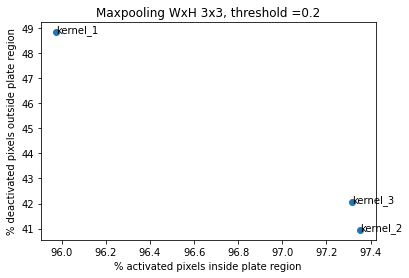

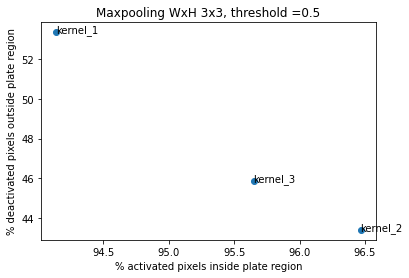

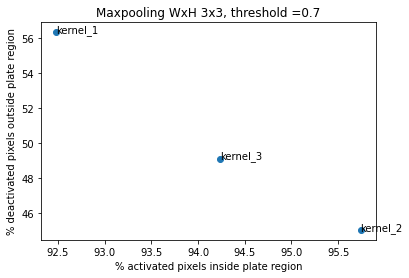

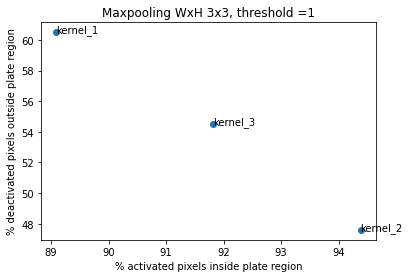

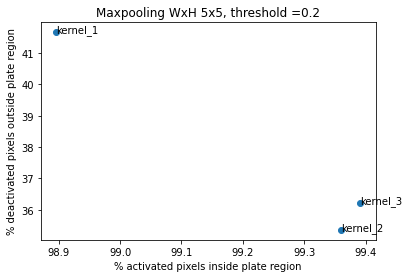

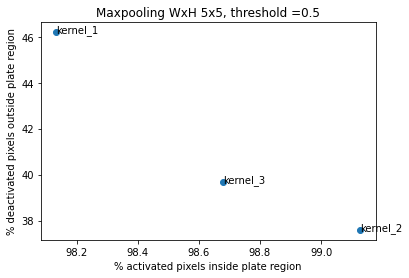

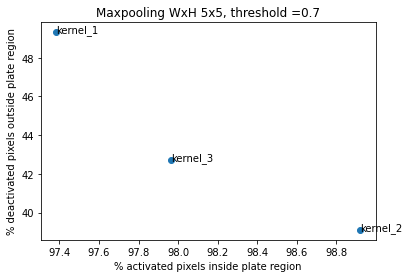

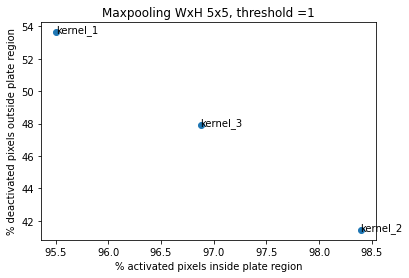

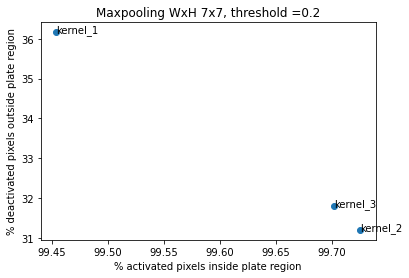

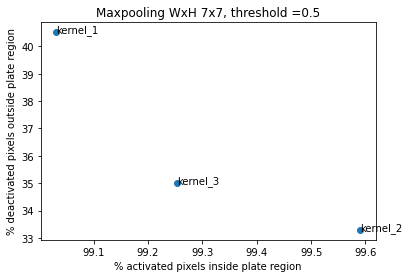

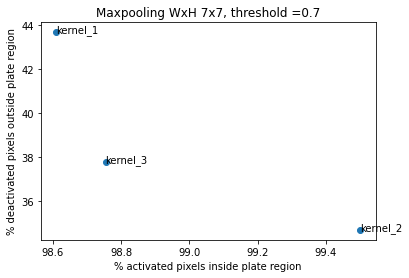

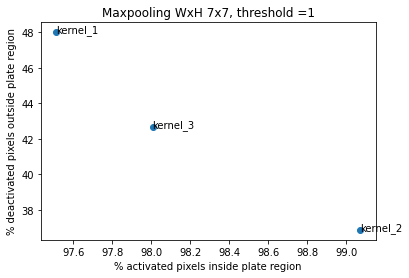

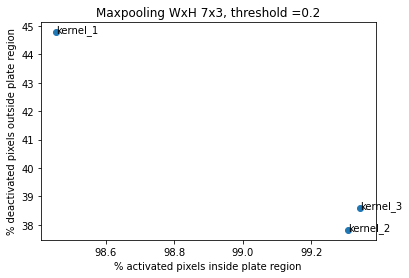

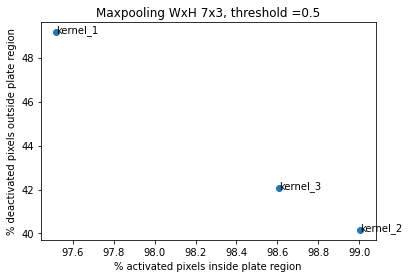

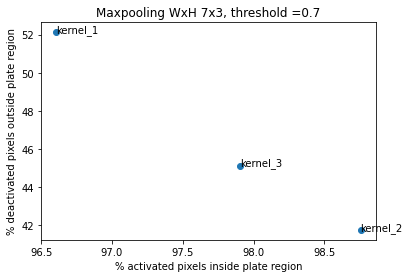

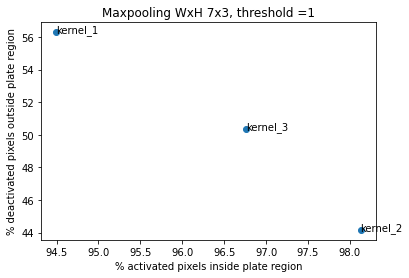

time: 10min 34s


In [259]:
foldername = "train11"
maskFolderPath = "/content/plates/"

for maxpoolResultsElem in maxpoolResults:
  for thresholdvalue in thresholdArray:
    titlestring = "Maxpooling WxH " + str(maxpoolResultsElem[0][0]) + "x" + str(maxpoolResultsElem[0][1]) + ", threshold =" + str(thresholdvalue)
    dfresults = computeResultsScores("Max pool", maxpoolResultsElem[1], foldername, maskFolderPath, thresholdvalue)
    scoresarray = computeScoresPerKernel(dfresults)
    plotScores(titlestring, scoresarray)

Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [86.16793118738879, 93.34832739915653, 89.55610008706486], [63.139603136013356, 49.424202395654746, 58.0968838951485]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [82.71741915105378, 92.15846383880914, 86.64527884589178], [65.70639789998681, 51.48934510444083, 61.609063168071444]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [78.76872871795324, 90.83509099039327, 83.1397113488751], [68.34627283449073, 53.840331282024614, 65.13390422197457]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [74.56370823753238, 89.15612454062875, 78.86819400260894], [71.03792200263209, 56.32048910462976, 68.47447286242894]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [70.37149252752334, 87.21100226221029, 74.190798392417], [73.66826173925163, 58.84758140125038, 71.82508132386532]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [93.76274885271827, 97.93538989780069, 95.7245546517401], [56.4052108535305, 43.099440388980

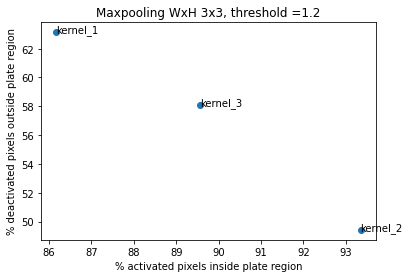

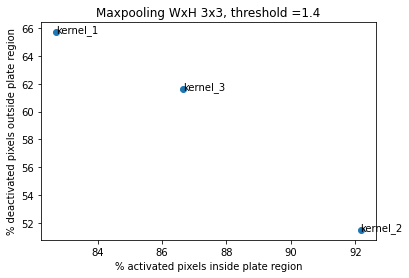

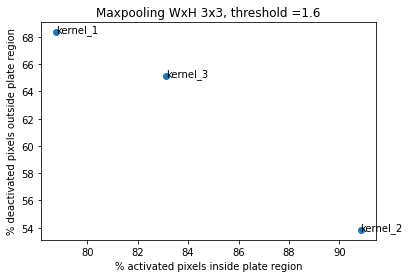

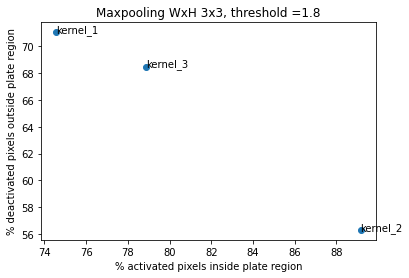

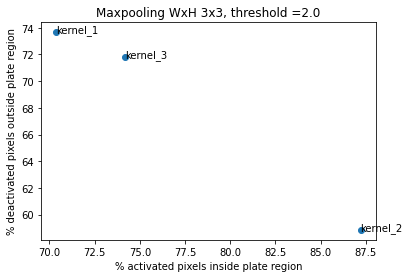

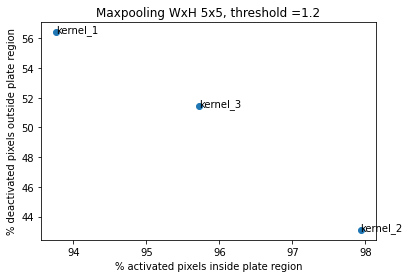

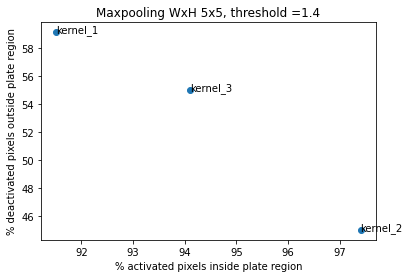

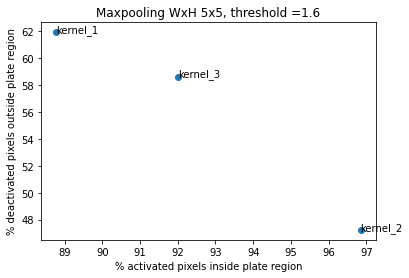

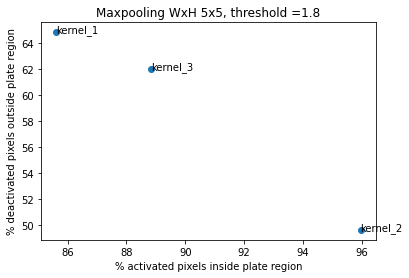

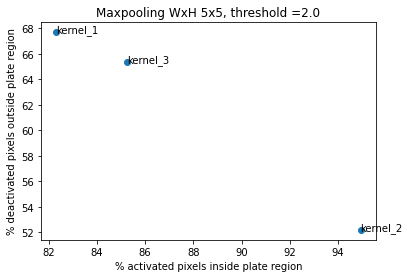

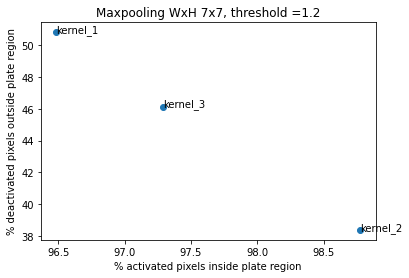

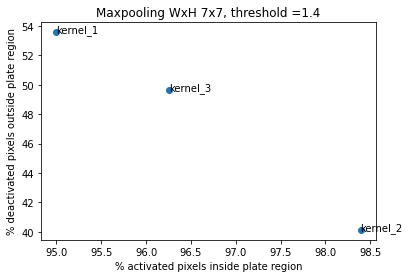

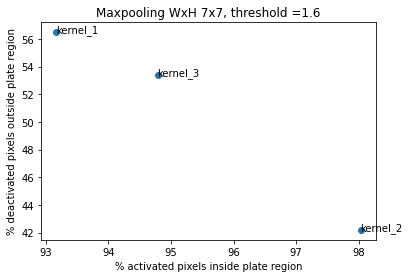

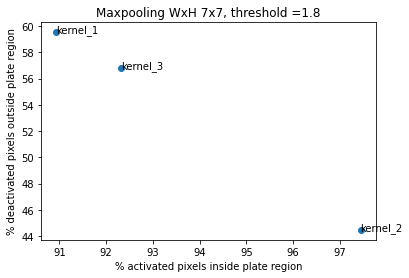

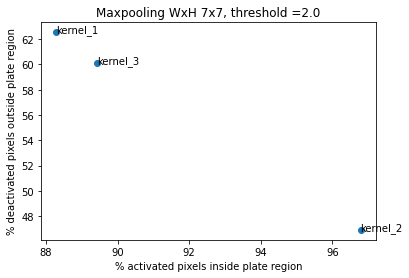

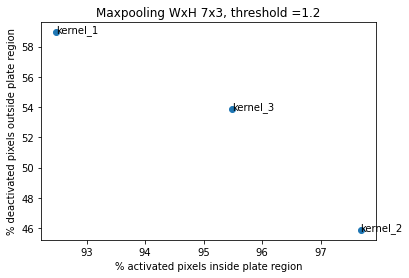

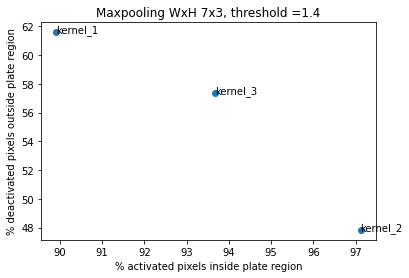

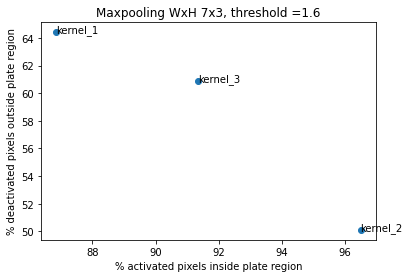

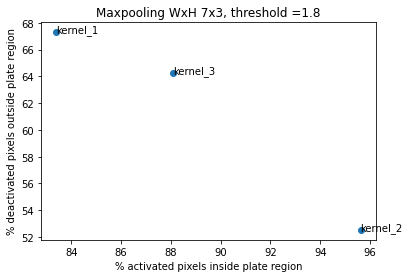

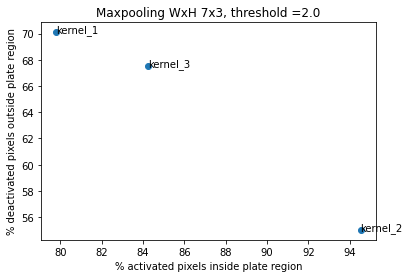

time: 13min 37s


In [26]:
foldername = "train11"
maskFolderPath = "/content/plates/"

thresholdArray = [1.2, 1.4, 1.6, 1.8, 2.]

for maxpoolResultsElem in maxpoolResults:
  for thresholdvalue in thresholdArray:
    titlestring = "Maxpooling WxH " + str(maxpoolResultsElem[0][0]) + "x" + str(maxpoolResultsElem[0][1]) + ", threshold =" + str(thresholdvalue)
    dfresults = computeResultsScores("Max pool", maxpoolResultsElem[1], foldername, maskFolderPath, thresholdvalue)
    scoresarray = computeScoresPerKernel(dfresults)
    plotScores(titlestring, scoresarray)

**Evaluating Average pooling**

In [ ]:
poolDimensions = [[3, 3], [5, 5], [7, 7], [7, 3]]

avgpoolResults = []

modelOutputresultsCopy = resultsarray[0].copy()

for poolDimensionPair in poolDimensions:
  avgpoolResultsInter = []
  for modeloutputresult in modelOutputresultsCopy:
    #getting the subimage after model transform
    modeloutputimage = modeloutputresult[1]
    modeloutputimagename = modeloutputresult[0]
    poolwidth = poolDimensionPair[0]
    poolheight = poolDimensionPair[1]
    
    averagepoolres = averagepooling(modeloutputimage, poolwidth, poolheight)
    avgpoolResultsInter.append([modeloutputimagename, averagepoolres])

  avgpoolResults.append([poolDimensionPair, avgpoolResultsInter])
  print("Maxpool with dimensions :", poolDimensionPair)
  print()

Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [91.89580420303628, 94.62736531614131, 93.18160585228615], [54.5920472863586, 44.666564226547635, 47.01527462847096]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [89.59819163079932, 93.11447836053452, 90.90838627180432], [57.15665842536387, 46.39209153388602, 49.44516511158429]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [87.09907497520912, 91.5584908568702, 88.56786020948002], [59.36123954249797, 47.964663536446395, 51.77388021402538]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [84.38521230859935, 90.10713867181698, 86.13970518693554], [61.4106305021487, 49.410839084550375, 54.06547981595735]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [78.70828022792064, 87.06818644819036, 81.00759186559242], [65.11357013688563, 52.03856643739757, 58.509199457994974]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [70.01654885883966, 82.08587003910864, 72.22661170339933], [69.79225046902258, 55.674976941

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [89.99663765124146, 95.82547325871839, 93.17054756530796], [58.94798886652934, 46.79683038867406, 50.89721006983511]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [87.05784615806631, 94.61487202049643, 90.97888590299709], [61.13809453318094, 48.33775491641623, 53.313850693553455]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [80.94504906492779, 91.94978812511148, 85.7253833199438], [64.78995033715404, 51.122604213802916, 57.91646866194943]]
Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [71.3753045530587, 86.99817613879279, 75.39782992293131], [69.36335573249654, 54.964963969646085, 64.30163212900813]]


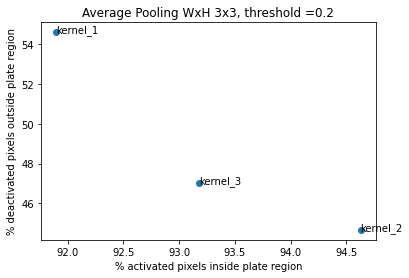

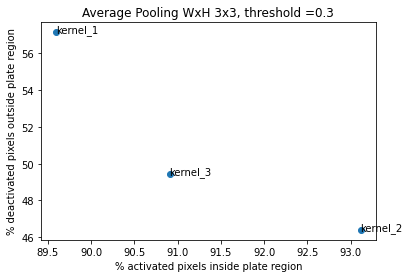

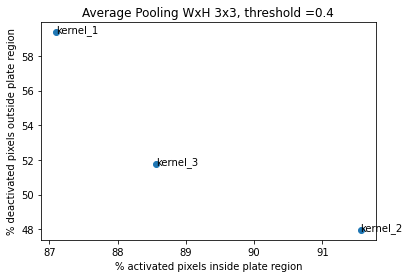

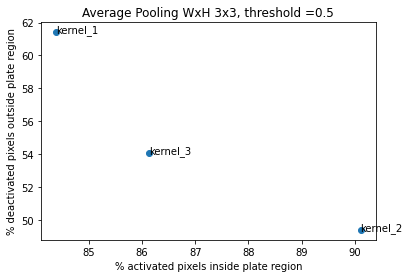

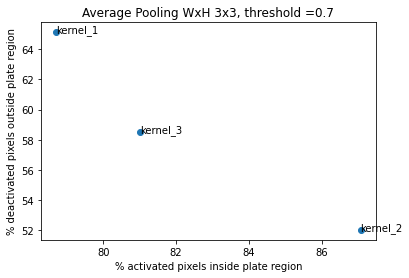

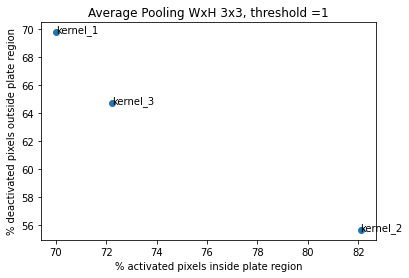

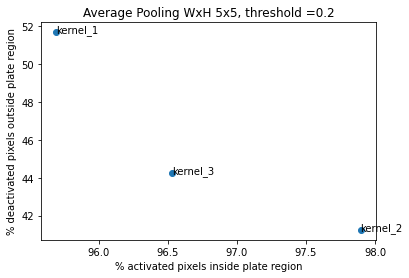

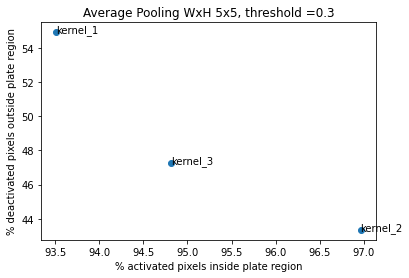

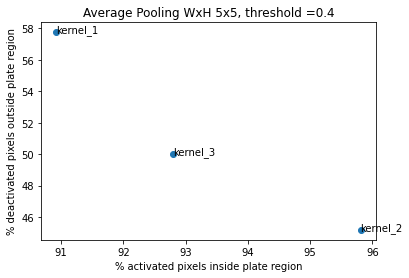

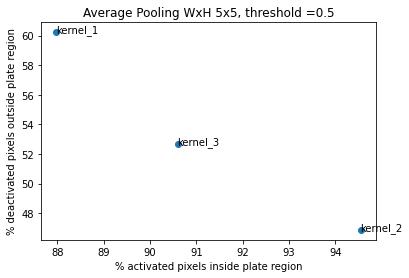

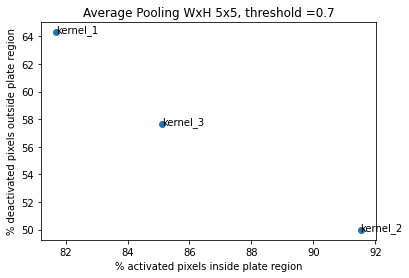

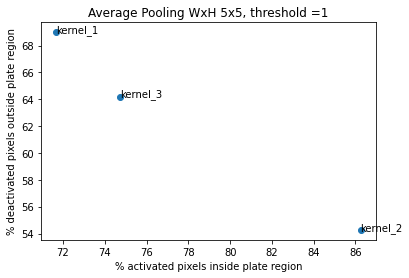

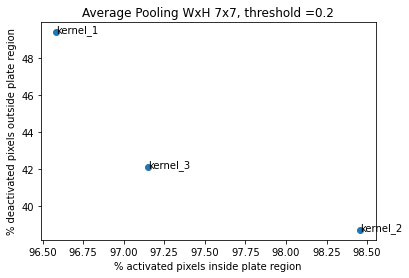

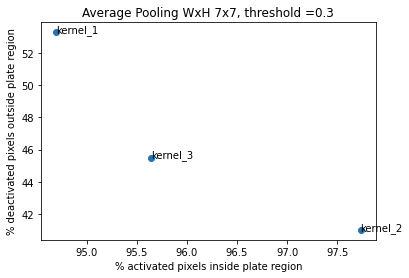

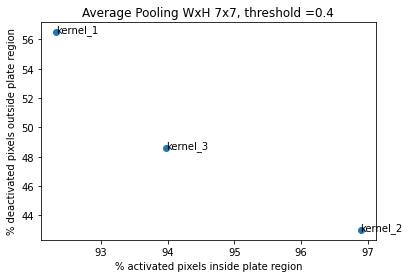

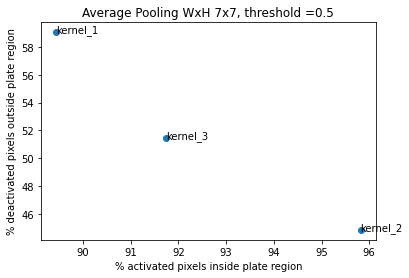

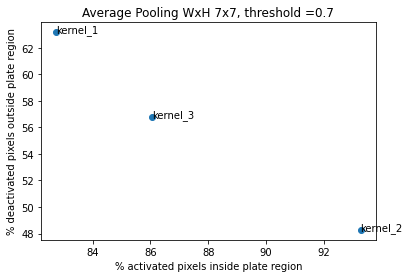

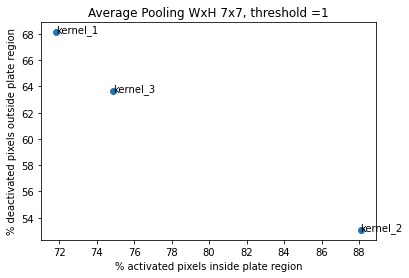

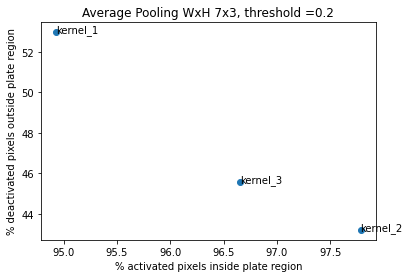

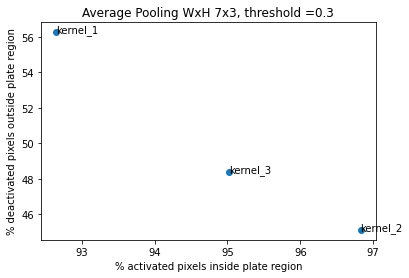

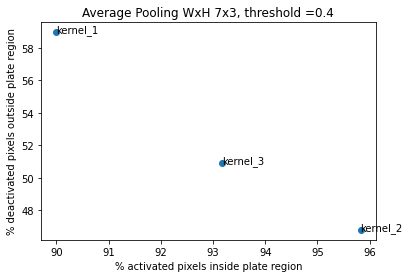

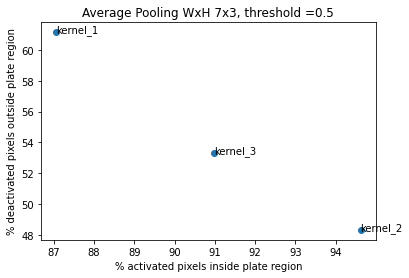

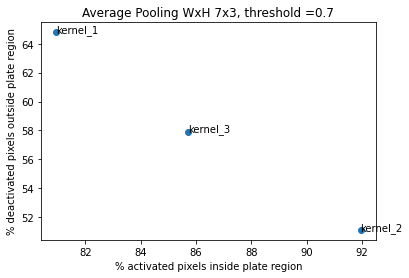

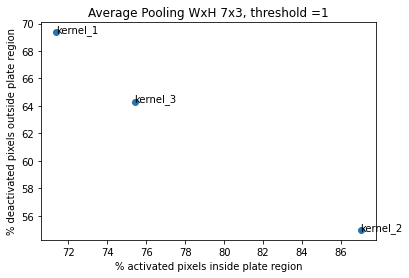

time: 15min 17s


In [23]:
maskFolderPath = "/content/plates/"
foldername = "train11"

thresholdArray = [0.2, 0.3, 0.4 ,0.5, 0.7, 1]

for avgpoolResultsElem in avgpoolResults:
  for thresholdvalue in thresholdArray:
    titlestring = "Average Pooling WxH " + str(avgpoolResultsElem[0][0]) + "x" + str(avgpoolResultsElem[0][1]) + ", threshold =" + str(thresholdvalue)
    dfresults = computeResultsScores("Average Pooling", avgpoolResultsElem[1], foldername, maskFolderPath, thresholdvalue)
    scoresarray = computeScoresPerKernel(dfresults)
    plotScores(titlestring, scoresarray)

###**Testing Poolings (Max-pool and average-pool) on test sets**

In [24]:
#evaluation on test set
def evaluatePoolOnTest(poolingtype, modelOutputresults, poolDimensionPair, threshold, testfoldername, maskfolderpathname ):

  poolwidth = poolDimensionPair[0]
  poolheight = poolDimensionPair[1]
  
  poolTESTResults = []
  poolResultsInter = []

  for modeloutputresult in modelOutputresults:
    
    #getting the subimage after model transform
    modeloutputimage = modeloutputresult[1]
    modeloutputimagename = modeloutputresult[0]
    
    poolres = []
    if poolingtype == "Max-pool":
      poolres = maxpooling(modeloutputimage, poolwidth, poolheight)
    else:
      poolres = averagepooling(modeloutputimage, poolwidth, poolheight)
    
    poolResultsInter.append([modeloutputimagename, poolres])
  
  poolTESTResults.append([poolDimensionPair, poolResultsInter])
  print(poolingtype, " with dimensions :", poolDimensionPair)
  print()

  for poolResultsElem in poolTESTResults:
    titlestring = poolingtype + " WxH " + str(poolResultsElem[0][0]) + "x" + str(poolResultsElem[0][1]) + ", threshold =" + str(threshold)
    dfpoolresults = computeResultsScores(poolingtype, poolResultsElem[1], testfoldername, maskfolderpathname, threshold)
    poolscoresarray = computeScoresPerKernel(dfpoolresults)
    plotScores(titlestring, poolscoresarray)


time: 13.2 ms


**Max-Pool tests:**

Max-pool  with dimensions : [7, 3]

Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [76.55243519924873, 92.72786687615344, 79.84810064501865], [70.51877276263865, 56.226107982263954, 67.91545879560921]]
Max-pool  with dimensions : [7, 3]

Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [78.04522860837211, 93.6773302415861, 82.53272896555096], [70.82148666763392, 56.32787280021812, 68.32479045109521]]
Max-pool  with dimensions : [7, 3]

Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [77.67773711882207, 94.07593177567094, 81.58319774806264], [71.2417464128259, 56.513773950150046, 68.82356008258276]]


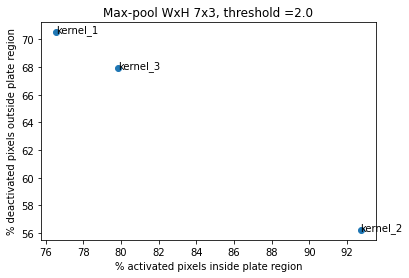

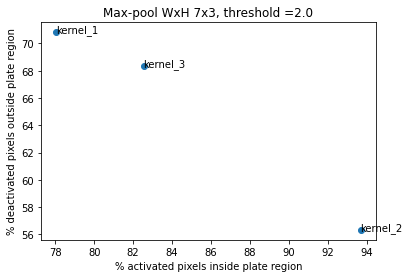

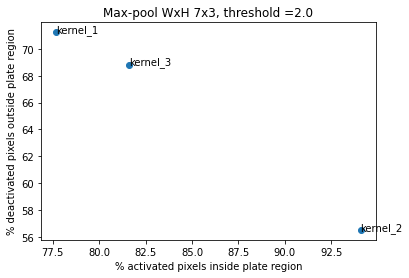

time: 25min 59s


In [25]:
pooltype = "Max-pool"
maskfolderpath = "/content/plates/"
bestpoolDimensionPair = [7,3]
bestthreshold = 2.0

TESTmodelOutputresults = testresultsarray.copy()

testfolderarray = ["test11", "test22", "test33" ] 

i = 0
for TESTmodelOutputresultArray in TESTmodelOutputresults:
  testFolderNam = testfolderarray[i]
  evaluatePoolOnTest(pooltype, TESTmodelOutputresultArray, bestpoolDimensionPair, bestthreshold, testFolderNam, maskfolderpath )
  i += 1

Average-pool  with dimensions : [7, 3]

Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [77.12154564097283, 90.45475506673053, 82.74871248454218], [65.89557989165125, 52.00413219459209, 59.03566874202891]]
Average-pool  with dimensions : [7, 3]

Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [79.4358736951387, 91.23864130283243, 84.88492819798606], [65.85649255064752, 52.24257671659611, 58.99672414419561]]
Average-pool  with dimensions : [7, 3]

Scores array  [['kernel_1', 'kernel_2', 'kernel_3'], [78.52553708422205, 91.37200621215652, 84.12812358714214], [66.18721894357917, 52.20014384389838, 59.32391971143436]]


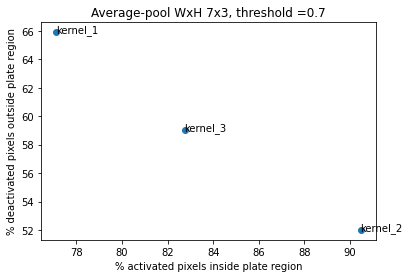

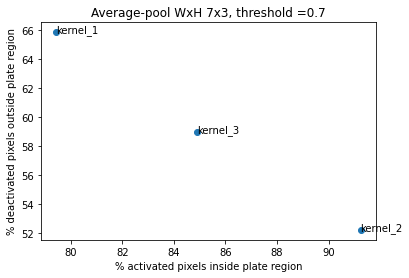

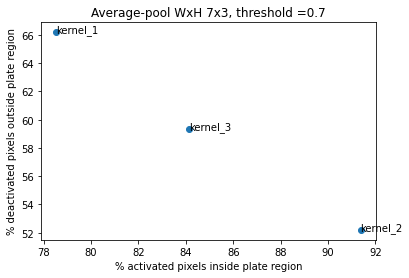

time: 47min 42s


In [26]:
pooltype = "Average-pool"
maskfolderpath = "/content/plates/"
bestpoolDimensionPair = [7,3]
bestthreshold = .7

TESTmodelOutputresults = testresultsarray.copy()

testfolderarray = ["test11", "test22", "test33" ] 

i = 0
for TESTmodelOutputresultArray in TESTmodelOutputresults:
  testFolderNam = testfolderarray[i]
  evaluatePoolOnTest(pooltype, TESTmodelOutputresultArray, bestpoolDimensionPair, bestthreshold, testFolderNam, maskfolderpath )
  i += 1

## **4 - Extracting haar-like features to enhance plate location**

We first define various regions R with size Wr x Hr, with varying definitions.

Programmatically, we define functions to compute the regions and that returns the new image with each pixel corresponding to the integral at each pixel of the original image. 

Then, it will be much easier to combine the various regions' output images into a weighted sum to get a new image with haar-like features.

In [106]:
#Region 1
def returnIntegralWithRegion1(regionwidth, regionheight1, regionheight2, subimage):
  height = subimage.shape[0]
  width = subimage.shape[1]
  bbands = subimage.shape[2]

  integralimage = np.zeros((height, width, bbands))
  
  b = 0
  while b < bbands:
    i = 0
    while i < height:
      j = 0
      while j < width:
        xstart = max( 0, j - regionwidth//2 )
        xend = min( width, j + regionwidth//2 + 1 )
        ystart = 0
        yend = min(height, i + regionheight1 + regionheight2//2 + 1 )
        subystart = max(0, i - regionheight2//2)
        integralimage[i][j][b] = subimage[ystart: yend, xstart:xend,b].sum() - subimage[subystart: i + 1, xstart:xend,b ].sum()
        j += 1  
      i += 1
    b += 1
  return integralimage

#Region 2
def returnIntegralWithRegion2(regionwidth, regionheight, subimage):
  height = subimage.shape[0]
  width = subimage.shape[1]
  bbands = subimage.shape[2]

  integralimage = np.zeros((height, width, bbands))
  
  b = 0
  while b < bbands:
    i = 0
    while i < height:
      j = 0
      while j < width:
        xstart = max( 0, j - regionwidth//2 )
        xend = min( width, j + regionwidth//2 + 1 )
        ystart = max(0, i -  regionheight//2 )
        yend = min(height, i + regionheight//2 + 1 )
        integralimage[i][j][b] = subimage[ystart: yend, xstart:xend,b].sum()
        j += 1  
      i += 1
    b += 1
  return integralimage 

#Region 3
def returnIntegralWithRegion3(regionwidth, regionheight2, regionheight3, subimage):
  height = subimage.shape[0]
  width = subimage.shape[1]
  bbands = subimage.shape[2]

  integralimage = np.zeros((height, width, bbands))
  
  b = 0
  while b < bbands:
    i = 0
    while i < height:
      j = 0
      while j < width:
        xstart = max( 0, j - regionwidth//2 )
        xend = min( width, j + regionwidth//2 + 1 )
        ystart = i
        yend = min(height, i + regionheight2//2 + regionheight3 + 1 )
        ysub = min(height, i + regionheight2//2 + 1)
        integralimage[i][j][b] = subimage[ystart: yend, xstart:xend,b].sum() - subimage[ystart: ysub, xstart:xend,b].sum()
        j += 1  
      i += 1
    b += 1
  return integralimage  

#Region 4
def returnIntegralWithRegion4(regionwidth, regionwidth4, regionheight, subimage):
  height = subimage.shape[0]
  width = subimage.shape[1]
  bbands = subimage.shape[2]

  integralimage = np.zeros((height, width, bbands))
  
  b = 0
  while b < bbands:
    i = 0
    while i < height:
      j = 0
      while j < width:
        xstart = 0
        xend = min( width, j + regionwidth4 + regionwidth//2 + 1 )
        xsub = max(0, j - regionwidth//2)
        ystart = max(0, i -  regionheight//2 )
        yend = min(height, i + regionheight//2 + 1 )
        integralimage[i][j][b] = subimage[ystart: yend, xstart:xend,b].sum() - subimage[ystart: yend, xsub: j + 1,b].sum()
        j += 1  
      i += 1
    b += 1
  return integralimage 


#Region 5
def returnIntegralWithRegion5(regionwidth, regionwidth5, regionheight, subimage):
  height = subimage.shape[0]
  width = subimage.shape[1]
  bbands = subimage.shape[2]

  integralimage = np.zeros((height, width, bbands))
  
  b = 0
  while b < bbands:
    i = 0
    while i < height:
      j = 0
      while j < width:
        xstart = j
        xsub = min(width, j + regionwidth//2 + 1)
        xend = min( width, j + regionwidth5 + regionwidth//2 + 1 )
        ystart = max(0, i -  regionheight//2 )
        yend = min(height, i + regionheight//2 + 1 )
        integralimage[i][j][b] = subimage[ystart: yend, xstart:xend,b].sum() - subimage[ystart: yend, xstart:xsub,b].sum()
        j += 1  
      i += 1
    b += 1
  return integralimage 

def returnRegionsIntegralBatch(inputimagearray, inputindexarray, regionsdimensions):
  integralRegionsOutput = []

  rw1, rh1, rw2, rh2, rw3, rh3, rw4, rh4, rw5, rh5 = regionsdimensions

  for index in inputindexarray:
    modeloutput = inputimagearray[index][1]
    oimagename = inputimagearray[index][0]

    ointegralregion1 = returnIntegralWithRegion1(rw1, rh1, rh2, modeloutput)
    ointegralregion2 = returnIntegralWithRegion2(rw2, rh2, modeloutput)
    ointegralregion3 = returnIntegralWithRegion3(rw3, rh2, rh3, modeloutput)
    ointegralregion4 = returnIntegralWithRegion4(rw2, rw4, rh4, modeloutput)
    ointegralregion5 = returnIntegralWithRegion5(rw2, rw5, rh5, modeloutput)

    integralRegionsOutput.append([oimagename, ointegralregion1, ointegralregion2, ointegralregion3, ointegralregion4, ointegralregion5])
  
  return integralRegionsOutput

time: 223 ms


**Now, we create the regions'integral for each image of training set 1**

We will focus on the images with class containing the plates with minmum threshold. 

In [101]:
train1modeloutputs = resultsarray[0].copy()

class1subimageIndexarray = []
class1subimageIDarray = []

count = 0
index = 0
for train1modeloutput in train1modeloutputs:
  oimagename = train1modeloutput[0]
  oimageID, owidth, oheight, oxcenter, oycenter, oimageclass = returnSubimageDimensionsCenterCoordinates(oimagename)
  if oimageclass == 1 and oimageID not in class1subimageIDarray:
    class1subimageIndexarray.append(index)
    class1subimageIDarray.append(oimageID)
    count += 1
  index += 1
print("Output images with class 1 count =", count)

Output images with class 1 count = 100
time: 12.5 ms


**Experiment 1:**

We define the dimensions of width and height for the regions as equal at first

In [107]:
regionsdimensionsarray = [5, 3, 5, 3, 5, 3, 5, 3, 5, 3]

train1regionsintegrals = returnRegionsIntegralBatch(train1modeloutputs, class1subimageIndexarray, regionsdimensionsarray)

time: 2min 24s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


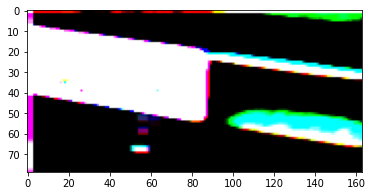

time: 180 ms


In [218]:
plt.imshow(train1regionsintegrals[30][2])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


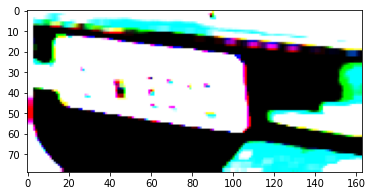

time: 173 ms


In [235]:
plt.imshow(train1regionsintegrals[33][2])
plt.show()

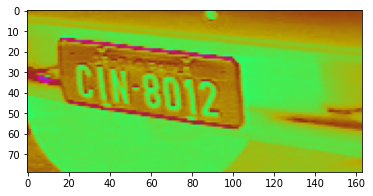

time: 188 ms


In [232]:
origsubimage = cv2.imread("train11/" + train1regionsintegrals[33][0])

plt.imshow(origsubimage)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


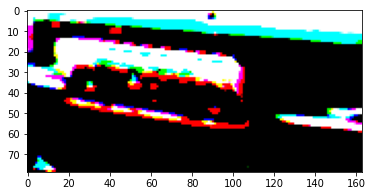

time: 181 ms


In [240]:
n = 33

regioncomp = 4*train1regionsintegrals[n][2] - 0.4 * train1regionsintegrals[n][1] -.4*  train1regionsintegrals[n][3]

plt.imshow(regioncomp)
plt.show()

Experiment 2

In [241]:
regionsdimensionsarray = [7, 3, 7, 3, 7, 3, 7, 3, 7, 3]

train1regionsintegrals2 = returnRegionsIntegralBatch(train1modeloutputs, class1subimageIndexarray, regionsdimensionsarray)

time: 2min 24s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


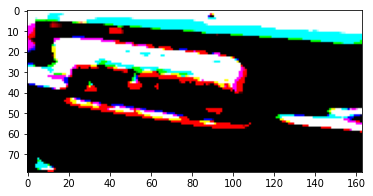

time: 181 ms


In [246]:
n = 33

regioncomp = 4*train1regionsintegrals2[n][2] - 0.4 * train1regionsintegrals2[n][1] -.4*  train1regionsintegrals2[n][3]

plt.imshow(regioncomp)
plt.show()

**Experiment 3**

In [242]:
regionsdimensionsarray = [5, 3, 7, 3, 5, 3, 5, 3, 5, 3]

train1regionsintegrals3 = returnRegionsIntegralBatch(train1modeloutputs, class1subimageIndexarray, regionsdimensionsarray)

time: 2min 21s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


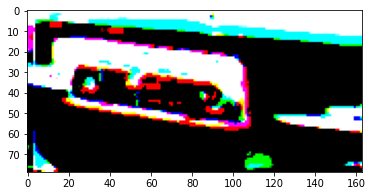

time: 192 ms


In [245]:
n = 33

regioncomp = 4*train1regionsintegrals3[n][2] - 0.4 * train1regionsintegrals3[n][1] -.4*  train1regionsintegrals3[n][3]

plt.imshow(regioncomp)
plt.show()

Experiment 4

In [243]:
regionsdimensionsarray = [5, 3, 5, 5, 5, 3, 5, 3, 5, 3]

train1regionsintegrals4 = returnRegionsIntegralBatch(train1modeloutputs, class1subimageIndexarray, regionsdimensionsarray)

time: 2min 21s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


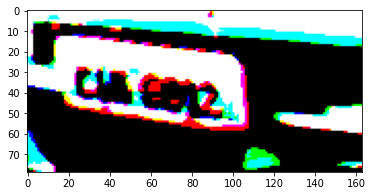

time: 189 ms


In [244]:
n = 33

regioncomp = 4*train1regionsintegrals4[n][2] - 0.4 * train1regionsintegrals4[n][1] -.4*  train1regionsintegrals4[n][3]

plt.imshow(regioncomp)
plt.show()

**Grid-search**

Build an index array containing a subset of class 0 and class 2 subimages

In [ ]:
#to do

In [ ]:
regionsdimensionsarray = [[5, 3, 5, 3, 5, 3, 5, 3, 5, 3], [7, 3, 7, 3, 7, 3, 7, 3, 7, 3], [5, 3, 7, 3, 5, 3, 5, 3, 5, 3], [5, 3, 5, 5, 5, 3, 5, 3, 5, 3]]

weightsRegionOneArray= [ -0.4, -0.6]
weightsRegionTwoArray= [ 2, 2.5, 4]
weightsRegionThreeArray= [ -.2, -.4, -.6]

trainmodeloutputs = resultsarray[0].copy()
subimagesIndexarray = 

for regDimensions in regionsdimensionsarray:
  regionIntegralsar = returnRegionsIntegralBatch(trainmodeloutputs, subimagesIndexarray, regDimensions)
  
  for weight1 in weightsRegionOneArray:
    for weight2 in weightsRegionOneArray:
      for weight3 in weightsRegionOneArray:
        
        

        regionsOutputs = returnRegionIntegralsBatchOutput(weight1, weight2, weight3, regionIntegralsar, [0, 1, 2])
        dfresults = computeResultsScores(modelname, maxpoolResultsElem[1], foldername, maskFolderPath, thresholdvalue)
        scoresarray = computeScoresPerKernel(dfresults)
        plotScores(titlestring, scoresarray)


In [ ]:
def returnRegionIntegralsBatchOutput(w0, w1, w2, regionIntegralsArray, indexArray):
  modelBatchOutput = []
  for regionIntegralsElem in regionIntegralsArray:
    imagename = regionIntegralsElem[0]
    bBandsImages = w0 * regionIntegralsElem[indexArray[0]] + w1 * regionIntegralsElem[indexArray[1]] + w2 * regionIntegralsElem[indexArray[2]]

    modelBatchOutput.append([imagename, bBandsImages])

  return modelBatchOutput